In [30]:
import sys
sys.executable

'D:\\Anaconda3\\envs\\gpwork\\python.exe'

* Документация по [History Callback](https://keras.io/callbacks/#history) на сайте Keras.
* Страница [TensorBoard]()

# Подключение библиотек

In [31]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.keras.utils import to_categorical
from tensorflow.keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Подключения библиотеки для разделения данных

In [32]:
from sklearn.model_selection import train_test_split

# TensorBoard and CallBacks

In [33]:
tensorboard = TensorBoard(log_dir='\tb_logs', histogram_freq=1, write_graph=True)
callback_list = [tensorboard]
print("TensorBoard and CallBacks init successful")

TensorBoard and CallBacks init successful


# Функция загрузки сигнала, Train и Test

In [41]:
def create_dataset(filepath):
    sgn = []
    lbl = []
    path = filepath + "/{}_data.txt"
    for i in range(0,10):
        data = np.loadtxt(path.format(i+1), dtype=np.float64)
        for j in range(np.shape(data)[0]):
            sgn.append(data[j, :])
            lbl.append(i)
    
    c = list(zip(sgn, lbl))
    shuffle(c)
    sgn, lbl = zip(*c)

    sgn = np.asarray(sgn, dtype=np.float64)
    lbl = np.asarray(lbl, dtype=np.int64)

    train_signals = sgn[0:int(0.6*len(sgn))]
    train_labels = lbl[0:int(0.6*len(lbl))]
    val_signals = sgn[int(0.6*len(sgn)):int(0.8*len(sgn))]
    val_labels = lbl[int(0.6*len(lbl)):int(0.8*len(lbl))]
    test_signals = sgn[int(0.8*len(sgn)):]
    test_labels = lbl[int(0.8*len(lbl)):]

    nrows, ncols = train_signals.shape
    train_signals = train_signals.reshape(nrows, ncols, 1)
    nrows, ncols = val_signals.shape
    val_signals = val_signals.reshape(nrows, ncols, 1)
    nrows, ncols = test_signals.shape
    test_signals = test_signals.reshape(nrows, ncols, 1)
    
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_signals, train_labels, val_signals, val_labels, test_signals, test_labels

# Функция отображения метрик

In [143]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

# Load data

In [42]:
files_path = "C:/Users/leoska/data_emg/" #path to your directory with 10 data.txt files
train_signals, train_labels, val_signals, val_labels, test_signals, test_labels = create_dataset(files_path)

print("Load data successful")

Load data successful


# Init train and test data

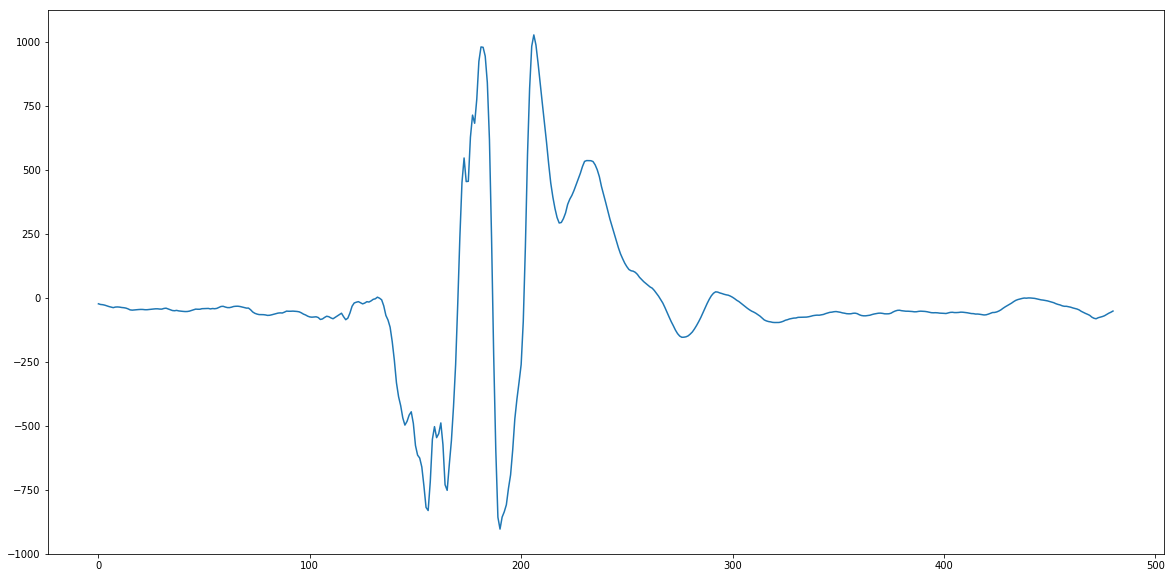

In [43]:
plt.figure(figsize=(20,10))
plt.plot(train_signals[2])
#plt.legend()

# Percentage of test data

In [46]:
print("Percentage of test data: {}%".format((test_size / len(test_signals)) * 100))

Percentage of test data: 0.2088607594936709%


# Parametrs

Произошла одна эпоха (*epoch*) — весь датасет прошел через нейронную сеть в прямом и обратном направлении только один раз.

Так как одна *epoch* слишком велика для компьютера, датасет делят на маленькие партии (*batches*).

Недостаточно одного полного прохода датасета через нейронную сеть, поэтому используем эпохи.

Нужно помнить, что мы используем ограниченный датасет, чтобы оптимизировать обучение и восстановить кривую сигнала.

In [161]:
encoding_dim = 128 # Hidden size (размер сжатого слоя слоя)
'''  '''
epochs = 100 # 5 эпох обучения
batch_size = 1024 #
num_classes = 10

In [162]:
print("Train signal shape: " + str(train_signals.shape))
print("Train labels shape: " + str(train_labels.shape))
print("Test signal shape: " + str(test_signals.shape))
print("Test labels shape: " + str(test_labels.shape))
print("Val signal shape: " + str(val_signals.shape))
print("Val labels shape: " + str(val_labels.shape))

Train signal shape: (474, 481, 1)
Train labels shape: (474, 10)
Test signal shape: (158, 481, 1)
Test labels shape: (158, 10)
Val signal shape: (158, 481, 1)
Val labels shape: (158, 10)


(474, 481, 1)
(158, 481, 1)
(474, 481)
(158, 481)
Tensor("input_50:0", shape=(None, 481), dtype=float32)


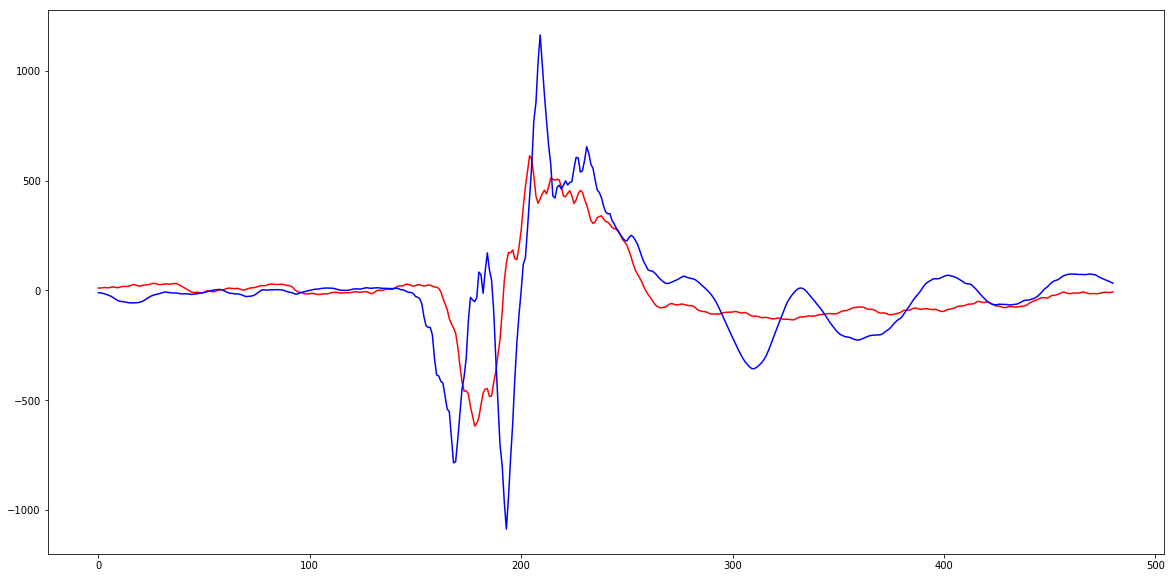

In [163]:
print(train_signals.shape)
print(test_signals.shape)

x_train_simple = np.asarray(train_signals).reshape((len(train_signals), np.prod(np.asarray(train_signals).shape[1:])))
x_test_simple = np.asarray(test_signals).reshape((len(test_signals), np.prod(np.asarray(test_signals).shape[1:])))

#print(x_train_simple.shape)
print(np.asarray(x_train_simple).shape)
print(np.asarray(x_test_simple).shape)

plt.figure(figsize=(20,10))
plt.plot(x_train_simple[3] ,'r')
plt.plot(x_test_simple[3] ,'b')

print(input_window)

# Настройки входого сигнала

In [ ]:
# длина сигнала
signal_len = 481
# количество сигналов
signal_count = 474
# количество каналов
inChannel = 1


# Simple feed-forward autoencoder

In [180]:
# this is our input placeholder
# 481 -  это размер одного сигнала
input_window = Input(shape=(signal_len,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(signal_len, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()
# mse - mean_squared_error
# metrics=['accuracy']
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=None,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 481)]             0         
_________________________________________________________________
dense_130 (Dense)            (None, 128)               61696     
_________________________________________________________________
dense_131 (Dense)            (None, 481)               62049     
Total params: 123,745
Trainable params: 123,745
Non-trainable params: 0
_________________________________________________________________
Train on 474 samples, validate on 158 samples
Epoch 1/100
474/474 [==============================] - ETA: 1s - loss: 187915.26 - 0s 470us/sample - loss: 147327.3475 - val_loss: 127042.9169
Epoch 2/100
474/474 [==============================] - ETA: 0s - loss: 122516.29 - 0s 105us/sample - loss: 147283.8669 - val_loss: 127016.7649
Epoch 3/100
474/474 [============================

Epoch 53/100
474/474 [==============================] - ETA: 0s - loss: 140081.28 - 0s 97us/sample - loss: 147202.5643 - val_loss: 126955.9367
Epoch 54/100
474/474 [==============================] - ETA: 0s - loss: 157177.81 - 0s 93us/sample - loss: 147202.5357 - val_loss: 126956.0157
Epoch 55/100
474/474 [==============================] - ETA: 0s - loss: 164795.06 - 0s 93us/sample - loss: 147202.3177 - val_loss: 126955.6269
Epoch 56/100
474/474 [==============================] - ETA: 0s - loss: 131421.50 - 0s 91us/sample - loss: 147202.1003 - val_loss: 126955.9541
Epoch 57/100
474/474 [==============================] - ETA: 0s - loss: 162383.40 - 0s 84us/sample - loss: 147202.7612 - val_loss: 126956.8720
Epoch 58/100
474/474 [==============================] - ETA: 0s - loss: 129440.96 - 0s 84us/sample - loss: 147203.0882 - val_loss: 126956.4847
Epoch 59/100
474/474 [==============================] - ETA: 0s - loss: 130398.49 - 0s 91us/sample - loss: 147202.6779 - val_loss: 126956.1368

# Plot history (Simple feed-forward autoencoder)

(158, 481)
dict_keys(['loss', 'val_loss'])


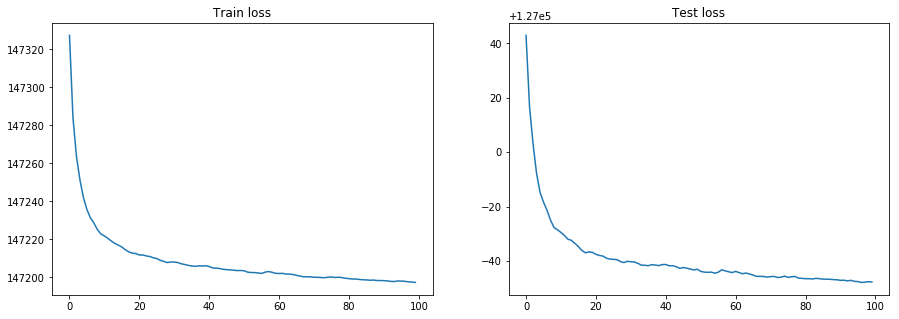

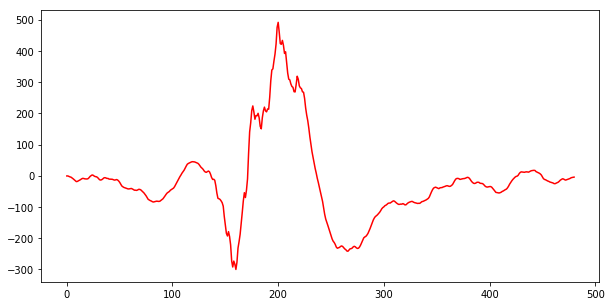

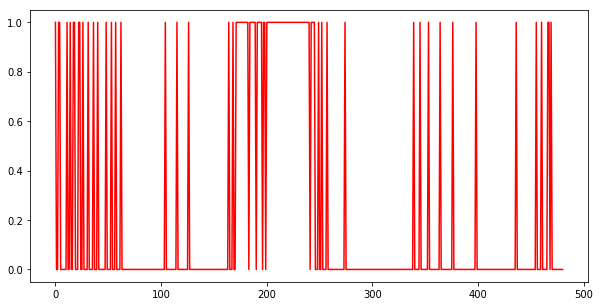

In [181]:
print(decoded_stocks.shape)
print(history.history.keys())

plot_history(history)

plt.figure(figsize=(10,5))
plt.plot(x_test_deep[0] ,'r')


plt.figure(figsize=(10,5))
plt.plot(decoded_stocks[0] ,'r')

#plot_examples(x_test_simple, decoded_stocks)

# Deep autoencoder

In [182]:
x_train_deep = np.asarray(train_signals).reshape((len(train_signals), np.prod(np.asarray(train_signals).shape[1:])))
x_test_deep = np.asarray(test_signals).reshape((len(test_signals), np.prod(np.asarray(test_signals).shape[1:])))

input_window = Input(shape=(signal_len,))

x = Dense(encoding_dim, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(encoding_dim, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(signal_len, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

(474, 481)
(158, 481)
Model: "model_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 481)]             0         
_________________________________________________________________
dense_132 (Dense)            (None, 128)               61696     
_________________________________________________________________
batch_normalization_v2_14 (B (None, 128)               512       
_________________________________________________________________
dense_133 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_134 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_v2_15 (B (None, 128)               512       
_________________________________________________________________
dense_135 (Dense)            (None,

Epoch 61/100
474/474 [==============================] - 0s 32us/sample - loss: 147220.7188 - val_loss: 126979.3438
Epoch 62/100
474/474 [==============================] - 0s 38us/sample - loss: 147220.0625 - val_loss: 126978.9844
Epoch 63/100
474/474 [==============================] - 0s 38us/sample - loss: 147219.3750 - val_loss: 126978.6328
Epoch 64/100
474/474 [==============================] - 0s 36us/sample - loss: 147218.7188 - val_loss: 126978.2656
Epoch 65/100
474/474 [==============================] - 0s 34us/sample - loss: 147218.0938 - val_loss: 126977.8750
Epoch 66/100
474/474 [==============================] - 0s 36us/sample - loss: 147217.4375 - val_loss: 126977.4922
Epoch 67/100
474/474 [==============================] - 0s 36us/sample - loss: 147216.8281 - val_loss: 126977.0859
Epoch 68/100
474/474 [==============================] - 0s 34us/sample - loss: 147216.1875 - val_loss: 126976.6719
Epoch 69/100
474/474 [==============================] - 0s 34us/sample - loss: 1

# Plot history (Deep autoencoder)

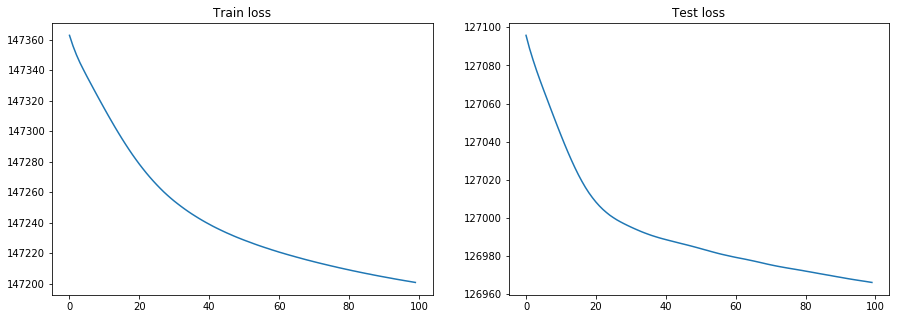

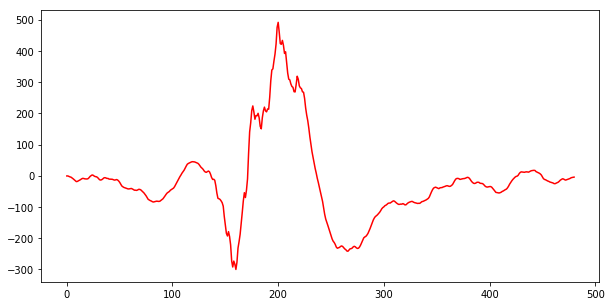

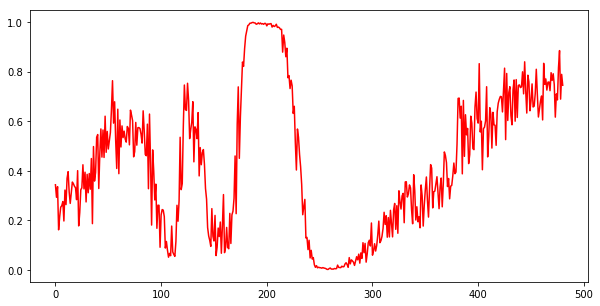

In [183]:
plot_history(history)

plt.figure(figsize=(10,5))
plt.plot(x_test_deep[0] ,'r')


plt.figure(figsize=(10,5))
plt.plot(decoded_stocks[0] ,'r')


# 1D Convolutional autoencoder (Здесь не правил - нужно грамотно настраивать слои)

In [12]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 1)              0         
__________

30121/30121 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - 1s 28us/step - loss: 0.6244 - val_loss: 0.6279
Epoch 33/100
30121/30121 [==============================] - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - 1s 28us/step - loss: 0.6241 - val_loss: 0.6276
Epoch 34/100
30121/30121 [==============================] - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.6

30121/30121 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - 1s 29us/step - loss: 0.6205 - val_loss: 0.6242
Epoch 69/100
30121/30121 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.619 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - 1s 28us/step - loss: 0.6205 - val_loss: 0.6243
Epoch 70/100
30121/30121 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.6

# Plot history (1D Convolutional autoencoder)

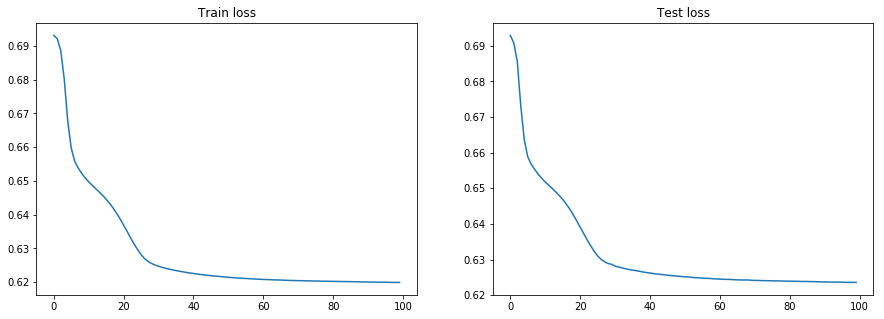

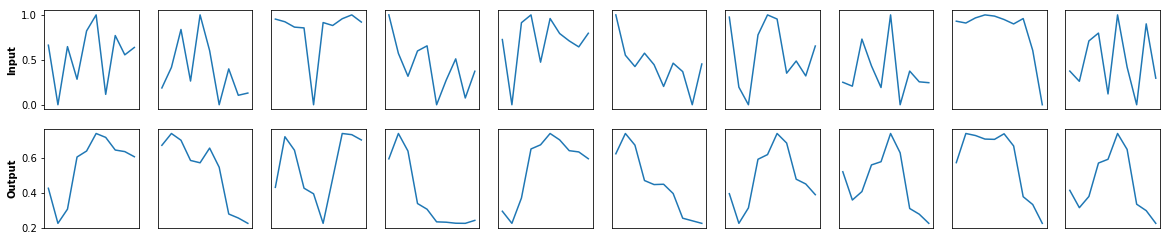

In [13]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)